$\newcommand{L}[1]{\| #1 \|}\newcommand{VL}[1]{\L{ \vec{#1} }}\newcommand{R}[1]{\operatorname{Re}\,(#1)}\newcommand{I}[1]{\operatorname{Im}\, (#1)}$

## Mutual information as an image matching metric

In which we look at the mutual information measure for comparing images.

In [1]:
# - compatibility with Python 2
from __future__ import print_function  # print('me') instead of print 'me'
from __future__ import division  # 1/2 == 0.5, not 0

In [2]:
# - import common modules
import numpy as np  # the Python array package
import matplotlib.pyplot as plt  # the Python plotting package

In [3]:
# - set gray colormap and nearest neighbor interpolation by default
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

In [4]:
%matplotlib inline

When the images to match are the same modality and are well aligned, the
signal should be similar in corresponding voxels. In that case, a metric like
correlation is useful as a measure of how well the images are matched.

If images are of different modalities, they may well have different signal
intensities for the same tissue.

For example, T1-weighted MRI images have low signal in the cerebro-spinal
fluid (CSF), but T2-weighted images have high signal in the CSF.

When the T1 and T2 images are well aligned, the voxels containing CSF will
correspond spatially, but they will have very different signal. In that case a
simple measure like correlation will not capture how well the two images are
matched.

Mutual information is a measure of image matching, that does not require the
signal to be the same in the two images. It is a measure of how well you can
predict the signal in the second image, given the signal intensity in the
first.

First let us look at a T1 and T2 image. In fact these images are from the
Montreal Neurological Institute (MNI) standard brain atlas :
[http://www.bic.mni.mcgill.ca/ServicesAtlases/ICBM152NLin2009](http://www.bic.mni.mcgill.ca/ServicesAtlases/ICBM152NLin2009). See the
[LICENSE](https://matthew-brett.github.io/teaching/_downloads/15e073449227fc6a31bb4db45d795839/LICENSE) file for copyright and usage of these images.

In [5]:
import nibabel as nib
t1_img = nib.load('mni_icbm152_t1_tal_nlin_asym_09a.nii')
t1_data = t1_img.get_data()
t2_img = nib.load('mni_icbm152_t2_tal_nlin_asym_09a.nii')
t2_data = t2_img.get_data()

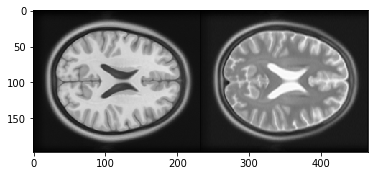

In [6]:
# Show the images by stacking them left-right with hstack
t1_slice = t1_data[:, :, 94]
t2_slice = t2_data[:, :, 94]
plt.imshow(np.hstack((t1_slice, t2_slice)))

The one-dimensional histograms of the example slices:

Text(0.5, 1.0, 'T2 slice histogram')

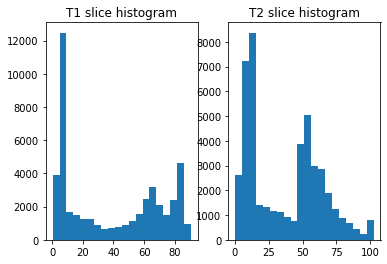

In [7]:
fig, axes = plt.subplots(1, 2)
axes[0].hist(t1_slice.ravel(), bins=20)
axes[0].set_title('T1 slice histogram')
axes[1].hist(t2_slice.ravel(), bins=20)
axes[1].set_title('T2 slice histogram')

Plotting the signal in the T1 slice against the signal in the T2 slice:

0.78707985510953

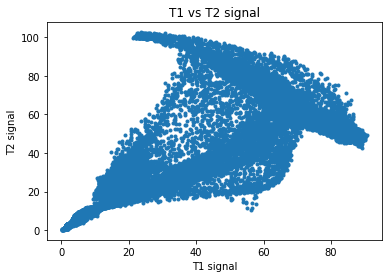

In [8]:
plt.plot(t1_slice.ravel(), t2_slice.ravel(), '.')
plt.xlabel('T1 signal')
plt.ylabel('T2 signal')
plt.title('T1 vs T2 signal')
np.corrcoef(t1_slice.ravel(), t2_slice.ravel())[0, 1]

Notice that we can predict the T2 signal given the T1 signal, but it is not a
linear relationship. For example, for T1 signal between 20 and 30, most
corresponding T2 signal is low, but there is some T2 signal that is high. This
pairing of high T2 signal with low T1 signal is from the CSF, which is dark
(low signal) in the T1, and bright in the T2.

Text(0.5, 1.0, 'T2 slice')

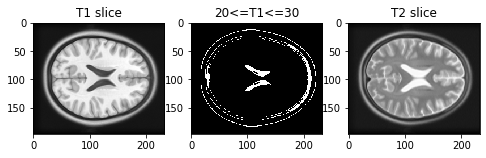

In [9]:
# Array that is True if T1 signal >= 20, <= 30, False otherwise
t1_20_30 = (t1_slice >= 20) & (t1_slice <= 30)
# Show T1 slice, mask for T1 between 20 and 30, T2 slice
fig, axes = plt.subplots(1, 3, figsize=(8, 3))
axes[0].imshow(t1_slice)
axes[0].set_title('T1 slice')
axes[1].imshow(t1_20_30)
axes[1].set_title('20<=T1<=30')
axes[2].imshow(t2_slice)
axes[2].set_title('T2 slice')

We can capture this more complicated relationship by doing a 2D histogram.
This is a histogram that divides the scatterplot into squares, and counts the
number of observations inside each square.

Look again at the [scatterplot for the T1 and T2 values](https://matthew-brett.github.io/teaching/mutual_information.html#t1-t2-scatter).
We get the 1D histogram for T1 values by splitting the x axis into bins, and
taking the number of observations contained in each column defined by the
bins.  The T2 histogram comes from splitting the y axis into bins and taking
the number of observations contained in each row defined by the bins.  The 2D
histogram comes from dividing both the x and the y axis into bins and taking
the number of observations in each square defined by the intersection of the
rows and columns:

Numpy has a function for doing the 2D histogram calculation:

Text(0, 0.5, 'T2 signal bin')

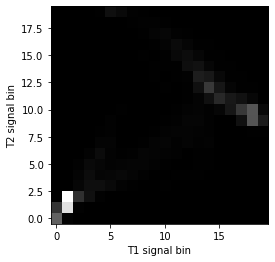

In [10]:
hist_2d, x_edges, y_edges = np.histogram2d(
    t1_slice.ravel(),
    t2_slice.ravel(),
    bins=20)
# Plot as image, arranging axes as for scatterplot
# We transpose to put the T1 bins on the horizontal axis
# and use 'lower' to put 0, 0 at the bottom of the plot
plt.imshow(hist_2d.T, origin='lower')
plt.xlabel('T1 signal bin')
plt.ylabel('T2 signal bin')

The histogram is easier to see if we show the log values to reduce the effect
of the bins with a very large number of values:

Text(0, 0.5, 'T2 signal bin')

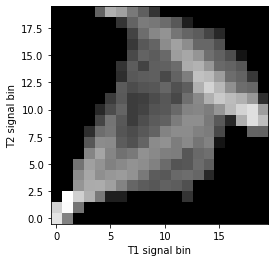

In [11]:
# Show log histogram, avoiding divide by 0
hist_2d_log = np.zeros(hist_2d.shape)
non_zeros = hist_2d != 0
hist_2d_log[non_zeros] = np.log(hist_2d[non_zeros])
plt.imshow(hist_2d_log.T, origin='lower')
plt.xlabel('T1 signal bin')
plt.ylabel('T2 signal bin')

Mutual information is a metric from the joint (2D) histogram. The metric is
high when the signal is highly concentrated in few bins (squares), and low
when the signal is spread across many bins (squares).

Mutual information is defined as:

$$
I(X;Y) = \sum_{y \in Y} \sum_{x \in X}
                 p(x,y) \log{ \left(\frac{p(x,y)}{p(x)\,p(y)}
                              \right) }
$$

See [http://en.wikipedia.org/wiki/Mutual_information](http://en.wikipedia.org/wiki/Mutual_information)

In [12]:
def mutual_information(hgram):
    """ Mutual information for joint histogram
    """
    # Convert bins counts to probability values
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1) # marginal for x over y
    py = np.sum(pxy, axis=0) # marginal for y over x
    px_py = px[:, None] * py[None, :] # Broadcast to multiply marginals
    # Now we can do the calculation using the pxy, px_py 2D arrays
    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

In [13]:
mutual_information(hist_2d)

1.3399511058289812

If we move the T2 image 15 pixels down, we make the images less well
registered.

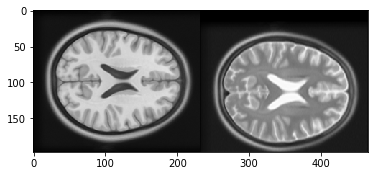

In [14]:
t2_slice_moved = np.zeros(t2_slice.shape)
t2_slice_moved[15:, :] = t2_slice[:-15, :]
plt.imshow(np.hstack((t1_slice, t2_slice_moved)))

Now the scatterplot is a lot more diffuse:

Text(0.5, 1.0, 'T1 vs T2 signal after moving T2 image')

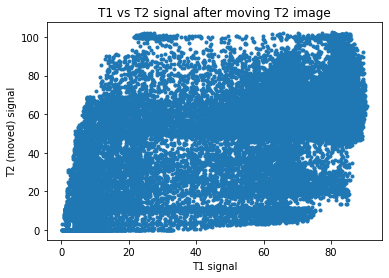

In [15]:
plt.plot(t1_slice.ravel(), t2_slice_moved.ravel(), '.')
plt.xlabel('T1 signal')
plt.ylabel('T2 (moved) signal')
plt.title('T1 vs T2 signal after moving T2 image')

The joint (2D) histogram shows the same thing:

In [16]:
hist_2d_moved, x_edges, y_edges = np.histogram2d(
    t1_slice.ravel(),
    t2_slice_moved.ravel(),
    bins=20)

Text(0, 0.5, 'T2 signal bin')

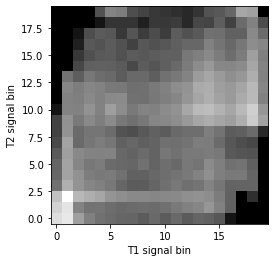

In [17]:
# Show log histogram, avoiding divide by 0
hist_2d_moved_log = np.zeros(hist_2d_moved.shape)
non_zeros = hist_2d_moved != 0
hist_2d_moved_log[non_zeros] = np.log(hist_2d_moved[non_zeros])
plt.imshow(hist_2d_moved_log.T, origin='lower')
plt.xlabel('T1 signal bin')
plt.ylabel('T2 signal bin')

Because the signal is less concentrated into a small number of bins, the
mutual information has dropped:

In [18]:
mutual_information(hist_2d_moved)

0.4577827377824529